In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import cross_val_score, cross_validate
#!pip install tensorcross
from tensorcross.model_selection import GridSearch

2022-12-14 11:00:40.865878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 11:00:40.865918: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Split the data into training, validation and testing

In [3]:
#set up some configuration variables
TRAIN_IMAGE_DIR = 'resized_dataset/Training'
TEST_IMAGE_DIR = 'resized_dataset/Testing'
img_height=167
img_width=167
batch_size=32

In order to follow the best ML practices, we will use some of the training data for validation. The dataset didn't have any validation data, and since we don't have much testing data either, we will take from the training dataset approx. 395 images for validation (which is also the number of images we have for testing). By a simple division we can see that we will use 13% of the training data for validation.
\
We will use the function *image_dataset_from_directory()* to create our train, test and validation datasets. This function is very suitable because we don't have a dataframe containing the class of each image, the images are ordered in folders based on their class. This function works with exactly this kind of input format.

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_IMAGE_DIR,
  validation_split=0.13,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 2497 files for training.


2022-12-14 11:01:36.589571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 11:01:36.589615: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 11:01:36.589640: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c100.local): /proc/driver/nvidia/version does not exist
2022-12-14 11:01:36.590114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_IMAGE_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [6]:
test_ds=tf.keras.utils.image_dataset_from_directory(
  TEST_IMAGE_DIR,
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

num_classes = 4

Found 394 files belonging to 4 classes.


### Simple Convolutional Neural Network

We will first try to train a simple CNN with 3 convolutional layers and see how good it can perform.

In [44]:
simple_cnn_model = tf.keras.Sequential([
  #rescale pixel values to [0,1] interval
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

simple_cnn_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

We will train it for 100 epochs and see the results.

In [45]:
history_simple_cnn=simple_cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
79/79 [==============================] - 15s 182ms/step - loss: 0.9073 - accuracy: 0.6175 - val_loss: 0.7518 - val_accuracy: 0.6672
Epoch 2/100
79/79 [==============================] - 14s 182ms/step - loss: 0.5792 - accuracy: 0.7661 - val_loss: 0.6039 - val_accuracy: 0.7578
Epoch 3/100
79/79 [==============================] - 14s 182ms/step - loss: 0.4331 - accuracy: 0.8350 - val_loss: 0.4690 - val_accuracy: 0.8258
Epoch 4/100
79/79 [==============================] - 14s 182ms/step - loss: 0.2689 - accuracy: 0.9035 - val_loss: 0.3969 - val_accuracy: 0.8641
Epoch 5/100
79/79 [==============================] - 14s 181ms/step - loss: 0.1430 - accuracy: 0.9495 - val_loss: 0.4265 - val_accuracy: 0.8554
Epoch 6/100
79/79 [==============================] - 14s 178ms/step - loss: 0.1052 - accuracy: 0.9688 - val_loss: 0.4300 - val_accuracy: 0.8937
Epoch 7/100
79/79 [==============================] - 14s 181ms/step - loss: 0.0663 - accuracy: 0.9744 - val_loss: 0.4296 - val_accuracy:

In [8]:
#save the trained model
simple_cnn_model.save("simple_cnn_100_epochs.h5")

In [46]:
#get the labels for the test images
test_labels = np.concatenate([y for x, y in test_ds], axis=0) 


In [47]:
#make predictions using our model
predicted_probabilities=simple_cnn_model.predict(test_ds)
predictions=np.argmax(predicted_probabilities, axis=1)
predictions

array([2, 1, 1, 3, 3, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 3, 1, 2, 1, 2, 1,
       2, 3, 2, 2, 1, 3, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 1, 1, 2,
       2, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [48]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy

#evaluate the model's performance using our chosen accuracy metric
compute_accuracy(test_labels, predictions)

0.751269035532995

Let's plot the model's accuracy and loss to try and get some insights about it.

In [11]:
def plot_accuracy(model_history, model_name):
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title(model_name+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(model_history, model_name):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

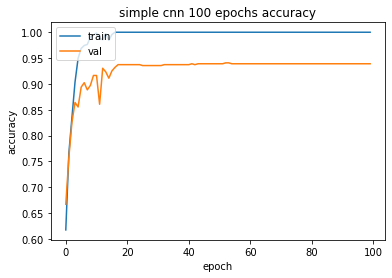

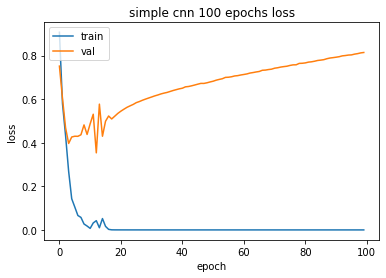

In [74]:
plot_accuracy(history_simple_cnn, "simple cnn 100 epochs")
plot_loss(history_simple_cnn, "simple cnn 100 epochs")

The first graph shows that the model isn't learning much more after around 20-30 epochs. The second graph shows that the model is overfitting, since the validation loss keeps increasing, even though the training loss keeps decreasing. This is a great insight that should help us improve the performance of our model.

## Improving the accuracy

The model performed really greatly and already exceeded our goal of 70% accuracy, but we will further try to get a better performance. The first technique we will try is to apply transfer learning. For this we will use the ResNet50 architecture, trained on the imagenet dataset.

### Resnet50 Transfer Learning

In [38]:
resnet = ResNet50(input_shape=(img_height,img_width,3), weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
    
#create the top layer used for prediction
x = layers.Flatten()(resnet.output)
prediction_layer = layers.Dense(num_classes, activation='softmax')(x)

# combine the bottom and top parts to finalize the model
resnet_model = Model(inputs=resnet.input, outputs=prediction_layer)

In [39]:
resnet_model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

First we will train it on 20 epochs only, because we can see from the previous training that the model

In [32]:
resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
79/79 [==============================] - 30s 376ms/step - loss: 0.5087 - accuracy: 0.9363 - val_loss: 0.7385 - val_accuracy: 0.9129
Epoch 2/20
79/79 [==============================] - 31s 389ms/step - loss: 0.2389 - accuracy: 0.9588 - val_loss: 0.4800 - val_accuracy: 0.9425
Epoch 3/20
79/79 [==============================] - 29s 368ms/step - loss: 0.1897 - accuracy: 0.9728 - val_loss: 0.6997 - val_accuracy: 0.9425
Epoch 4/20
79/79 [==============================] - 29s 366ms/step - loss: 0.1421 - accuracy: 0.9772 - val_loss: 0.3844 - val_accuracy: 0.9460
Epoch 5/20
79/79 [==============================] - 29s 373ms/step - loss: 0.0520 - accuracy: 0.9904 - val_loss: 0.5634 - val_accuracy: 0.9355
Epoch 6/20
79/79 [==============================] - 30s 385ms/step - loss: 0.1459 - accuracy: 0.9796 - val_loss: 0.9102 - val_accuracy: 0.9268
Epoch 7/20
79/79 [==============================] - 30s 377ms/step - loss: 0.0722 - accuracy: 0.9868 - val_loss: 0.6305 - val_accuracy: 0.9443

In [33]:
predicted_probabilities_resnet=resnet_model.predict(test_ds)
predictions_resnet=np.argmax(predicted_probabilities_resnet, axis=1)
predictions_resnet

array([3, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 3, 2, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 3, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [34]:
compute_accuracy(test_labels, predictions_resnet)

0.748730964467005

In [36]:
resnet_model.save("resnet_transfer_learning_20_epochs.h5")

In [40]:
resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
79/79 [==============================] - 35s 394ms/step - loss: 4.1482 - accuracy: 0.7445 - val_loss: 1.0082 - val_accuracy: 0.8868
Epoch 2/50
79/79 [==============================] - 31s 389ms/step - loss: 0.4936 - accuracy: 0.9315 - val_loss: 0.9797 - val_accuracy: 0.8972
Epoch 3/50
79/79 [==============================] - 31s 392ms/step - loss: 0.1193 - accuracy: 0.9764 - val_loss: 0.8195 - val_accuracy: 0.9216
Epoch 4/50
79/79 [==============================] - 31s 398ms/step - loss: 0.1026 - accuracy: 0.9812 - val_loss: 0.4668 - val_accuracy: 0.9460
Epoch 5/50
79/79 [==============================] - 31s 391ms/step - loss: 0.0477 - accuracy: 0.9880 - val_loss: 0.7446 - val_accuracy: 0.9268
Epoch 6/50
79/79 [==============================] - 31s 393ms/step - loss: 0.1014 - accuracy: 0.9844 - val_loss: 1.6707 - val_accuracy: 0.8659
Epoch 7/50
79/79 [==============================] - 30s 385ms/step - loss: 0.1436 - accuracy: 0.9772 - val_loss: 0.8800 - val_accuracy: 0.9268

In [41]:
resnet_model.save("resnet_transfer_learning_50_epochs.h5")

In [42]:
predicted_probabilities_resnet=resnet_model.predict(test_ds)
predictions_resnet=np.argmax(predicted_probabilities_resnet, axis=1)
predictions_resnet

array([3, 1, 2, 3, 3, 3, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 3, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 1, 2,
       1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [43]:
compute_accuracy(test_labels, predictions_resnet)

0.7563451776649747

### Resnet50 with trainable weights

In [67]:
# train existing weights
for layer in resnet.layers:
    layer.trainable = False

#create the top layer used for prediction
x = layers.Flatten()(resnet.output)
prediction_layer = layers.Dense(num_classes, activation='softmax')(x)

# combine the bottom and top parts to finalize the model
resnet_trainable_model = Model(inputs=resnet.input, outputs=prediction_layer)
resnet_trainable_model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
         
history_resnet_trainable=resnet_trainable_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
79/79 [==============================] - 35s 404ms/step - loss: 4.8463 - accuracy: 0.7453 - val_loss: 0.8271 - val_accuracy: 0.8972
Epoch 2/50
79/79 [==============================] - 31s 389ms/step - loss: 0.5775 - accuracy: 0.9287 - val_loss: 0.8404 - val_accuracy: 0.8972
Epoch 3/50
79/79 [==============================] - 30s 385ms/step - loss: 0.2152 - accuracy: 0.9716 - val_loss: 0.5175 - val_accuracy: 0.9355
Epoch 4/50
79/79 [==============================] - 31s 388ms/step - loss: 0.0671 - accuracy: 0.9856 - val_loss: 0.7778 - val_accuracy: 0.8990
Epoch 5/50
79/79 [==============================] - 31s 392ms/step - loss: 0.2319 - accuracy: 0.9644 - val_loss: 1.2303 - val_accuracy: 0.8990
Epoch 6/50
79/79 [==============================] - 32s 399ms/step - loss: 0.1337 - accuracy: 0.9772 - val_loss: 0.8346 - val_accuracy: 0.9164
Epoch 7/50
79/79 [==============================] - 30s 384ms/step - loss: 0.2625 - accuracy: 0.9676 - val_loss: 0.6250 - val_accuracy: 0.9443

In [68]:
resnet_trainable_model.save("resnet_trainable_50_epochs.h5")

In [69]:
predicted_probabilities_resnet_trainable=resnet_trainable_model.predict(test_ds)
predictions_resnet_trainable=np.argmax(predicted_probabilities_resnet_trainable, axis=1)
compute_accuracy(test_labels, predictions_resnet_trainable)

0.7360406091370558

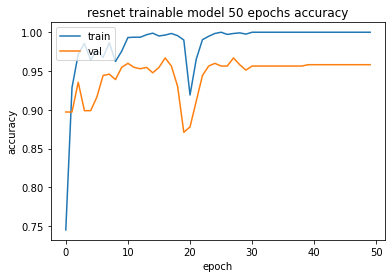

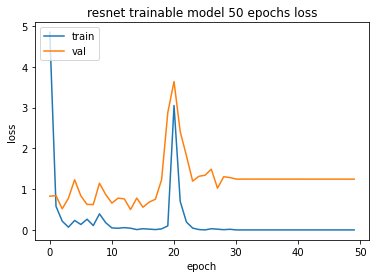

In [76]:
plot_accuracy(history_resnet_trainable, "resnet trainable model 50 epochs")
plot_loss(history_resnet_trainable, "resnet trainable model 50 epochs")

### Hyperparameter Tuning

The performance of the model is not great compared to the longer training time it requires. Since the ResNet models seem to be overfitting (i.e. they are too complex), we will focus on improving the simple CNN model and improve its accuracy. So far we've only played around with one Hyperparameter, which is the number of epochs. Let's try to perform some hyperparameter tuning and thus try to make the model perform better.<br>
Due to the fact that Tensorflow doesn't have GridSearch implemented by default (like in scikit-learn), we will use the library *tensorcross* which implements it in tensorflow.
<br>
Due to the very limited computing power available for me, we will use a rather small search space for GridSearch.

In [54]:


# def build_model():
#   model = tf.keras.Sequential([
#   #rescale pixel values to [0,1] interval
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

#   model.compile(
#   optimizer='adam',
#   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])
#   return model

def build_model(
        optimizer: tf.keras.optimizers.Optimizer,
        learning_rate: float
    ) -> tf.keras.models.Model:
        x_input = tf.keras.layers.Input(shape=2)
        y_pred = tf.keras.layers.Dense(units=1)(x_input)
        model = tf.keras.Sequential([
        #rescale pixel values to [0,1] interval
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
])

        opt = optimizer(learning_rate=learning_rate)

        model.compile(
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=["accuracy"]
        )

        return model

In [56]:
param_grid = {
        "optimizer": [
            tf.keras.optimizers.Adam,
            tf.keras.optimizers.RMSprop
        ],
        "learning_rate": [0.001, 0.0001]
    }
grid_search = GridSearch(
        model_fn=build_model,
        param_grid=param_grid,
        verbose=1
    )
grid_search.fit(
        train_dataset=train_ds,
        val_dataset=val_ds,
        epochs=20,
        verbose=1
    )
grid_search.summary()

Running Comb: 0
Epoch 1/20
79/79 [==============================] - 15s 184ms/step - loss: 1.0059 - accuracy: 0.5635 - val_loss: 0.7707 - val_accuracy: 0.6986
Epoch 2/20
79/79 [==============================] - 15s 184ms/step - loss: 0.6382 - accuracy: 0.7325 - val_loss: 0.5878 - val_accuracy: 0.7352
Epoch 3/20
79/79 [==============================] - 14s 181ms/step - loss: 0.4445 - accuracy: 0.8210 - val_loss: 0.4739 - val_accuracy: 0.8328
Epoch 4/20
79/79 [==============================] - 14s 183ms/step - loss: 0.2845 - accuracy: 0.8999 - val_loss: 0.8325 - val_accuracy: 0.6951
Epoch 5/20
79/79 [==============================] - 14s 183ms/step - loss: 0.3024 - accuracy: 0.8859 - val_loss: 0.2923 - val_accuracy: 0.8902
Epoch 6/20
79/79 [==============================] - 15s 184ms/step - loss: 0.1407 - accuracy: 0.9499 - val_loss: 0.3420 - val_accuracy: 0.8868
Epoch 7/20
79/79 [==============================] - 14s 180ms/step - loss: 0.0839 - accuracy: 0.9736 - val_loss: 0.2822 - val_

"\n--------------------------------------------------------------------------------------------------------------------------------\nBest score: 0.9285714030265808 using params: {'learning_rate': 0.001, 'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>}\n--------------------------------------------------------------------------------------------------------------------------------Idx: 0 - Score: 0.9233449697494507 with param: {'learning_rate': 0.001, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>}Idx: 1 - Score: 0.9285714030265808 with param: {'learning_rate': 0.001, 'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>}Idx: 2 - Score: 0.8989546895027161 with param: {'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>}Idx: 3 - Score: 0.904181182384491 with param: {'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizer_v2.rmsprop.RMSprop'>}----------------------------------------------------------------------------------------------------

Let's see if we can improve the model's performance if we use the best hyperparameters and give it a bit more epochs to learn.

In [65]:
cnn_model_improved = tf.keras.Sequential([
  #rescale pixel values to [0,1] interval
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

cnn_model_improved.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history_cnn_model_improved=cnn_model_improved.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
79/79 [==============================] - 16s 188ms/step - loss: 0.9652 - accuracy: 0.5867 - val_loss: 0.7836 - val_accuracy: 0.6690
Epoch 2/100
79/79 [==============================] - 15s 187ms/step - loss: 0.5975 - accuracy: 0.7509 - val_loss: 0.7333 - val_accuracy: 0.7003
Epoch 3/100
79/79 [==============================] - 15s 190ms/step - loss: 0.4060 - accuracy: 0.8350 - val_loss: 0.9041 - val_accuracy: 0.7003
Epoch 4/100
79/79 [==============================] - 15s 185ms/step - loss: 0.2515 - accuracy: 0.9091 - val_loss: 0.4006 - val_accuracy: 0.8502
Epoch 5/100
79/79 [==============================] - 15s 187ms/step - loss: 0.1581 - accuracy: 0.9415 - val_loss: 0.2945 - val_accuracy: 0.9146
Epoch 6/100
79/79 [==============================] - 15s 189ms/step - loss: 0.0874 - accuracy: 0.9692 - val_loss: 0.3104 - val_accuracy: 0.8972
Epoch 7/100
79/79 [==============================] - 15s 189ms/step - loss: 0.0617 - accuracy: 0.9796 - val_loss: 0.3460 - val_accuracy:

In [66]:
predicted_probabilities_resnet=cnn_model_improved.predict(test_ds)
predictions_improved_model=np.argmax(predicted_probabilities_resnet, axis=1)
test_labels = np.concatenate([y for x, y in test_ds], axis=0) 
compute_accuracy(test_labels,predictions_improved_model)

0.7461928934010152

Sadly the result didn't improve. Let's also try to optimize the batch size parameter.

In [67]:
def build_model(
        batch_size: int
    ) -> tf.keras.models.Model:
        x_input = tf.keras.layers.Input(shape=2)
        y_pred = tf.keras.layers.Dense(units=1)(x_input)
        model = tf.keras.Sequential([
        #rescale pixel values to [0,1] interval
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
])



        model.compile(
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics=["accuracy"]
        )

        return model
    
param_grid = {
        "batch_size": [10, 20,30]
    }
grid_search = GridSearch(
        model_fn=build_model,
        param_grid=param_grid,
        verbose=1
    )
grid_search.fit(
        train_dataset=train_ds,
        val_dataset=val_ds,
        epochs=20,
        verbose=1
    )
grid_search.summary()

Running Comb: 0
Epoch 1/20
79/79 [==============================] - 16s 190ms/step - loss: 1.0366 - accuracy: 0.5703 - val_loss: 0.7989 - val_accuracy: 0.6725
Epoch 2/20
79/79 [==============================] - 15s 186ms/step - loss: 0.6477 - accuracy: 0.7277 - val_loss: 0.7687 - val_accuracy: 0.7125
Epoch 3/20
79/79 [==============================] - 15s 187ms/step - loss: 0.4648 - accuracy: 0.8030 - val_loss: 1.3979 - val_accuracy: 0.5418
Epoch 4/20
79/79 [==============================] - 15s 193ms/step - loss: 0.3090 - accuracy: 0.8823 - val_loss: 0.4386 - val_accuracy: 0.8641
Epoch 5/20
79/79 [==============================] - 15s 187ms/step - loss: 0.1993 - accuracy: 0.9223 - val_loss: 0.3712 - val_accuracy: 0.8833
Epoch 6/20
79/79 [==============================] - 15s 190ms/step - loss: 0.1497 - accuracy: 0.9495 - val_loss: 0.3329 - val_accuracy: 0.9059
Epoch 7/20
79/79 [==============================] - 15s 187ms/step - loss: 0.0947 - accuracy: 0.9712 - val_loss: 0.3678 - val_

"\n---------------------------------------------------------------\nBest score: 0.9390243887901306 using params: {'batch_size': 30}\n---------------------------------------------------------------Idx: 0 - Score: 0.9303135871887207 with param: {'batch_size': 10}Idx: 1 - Score: 0.9320557713508606 with param: {'batch_size': 20}Idx: 2 - Score: 0.9390243887901306 with param: {'batch_size': 30}---------------------------------------------------------------\n"

It looks like a bigger batch size seems to give better results. Unfortunately, in the previous experiments we were using the default batch_size of 32, so this won't effect the results of our model much. <br>

### Network architecture

Another possible hyperparameters that we could play with are the number of layers in the network and the number of filters per layer. Next we will try to play around with different configurations and see if we can improve our results.<br>
Since the model was overfitting, we will try to make it less complex by removing one convolutional layer.

In [8]:
#remove one convolutional layer
cnn_model_2_layers = tf.keras.Sequential([
  #rescale pixel values to [0,1] interval
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

cnn_model_2_layers.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history_cnn_model_2_layers=cnn_model_2_layers.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
79/79 [==============================] - 16s 197ms/step - loss: 1.2065 - accuracy: 0.6095 - val_loss: 4.3179 - val_accuracy: 0.2544
Epoch 2/50
79/79 [==============================] - 15s 189ms/step - loss: 0.5363 - accuracy: 0.8042 - val_loss: 0.4671 - val_accuracy: 0.8118
Epoch 3/50
79/79 [==============================] - 15s 188ms/step - loss: 0.2491 - accuracy: 0.9103 - val_loss: 0.4080 - val_accuracy: 0.8711
Epoch 4/50
79/79 [==============================] - 15s 191ms/step - loss: 0.1398 - accuracy: 0.9479 - val_loss: 0.2946 - val_accuracy: 0.8955
Epoch 5/50
79/79 [==============================] - 15s 190ms/step - loss: 0.0777 - accuracy: 0.9728 - val_loss: 0.3310 - val_accuracy: 0.9094
Epoch 6/50
79/79 [==============================] - 15s 191ms/step - loss: 0.0520 - accuracy: 0.9844 - val_loss: 0.4412 - val_accuracy: 0.9007
Epoch 7/50
79/79 [==============================] - 15s 194ms/step - loss: 0.0482 - accuracy: 0.9884 - val_loss: 0.3124 - val_accuracy: 0.9129

In [9]:
predicted_probabilities=cnn_model_2_layers.predict(test_ds)
predictions_model_2_layers=np.argmax(predicted_probabilities, axis=1)
test_labels = np.concatenate([y for x, y in test_ds], axis=0) 
compute_accuracy(test_labels,predictions_model_2_layers)

0.7360406091370558

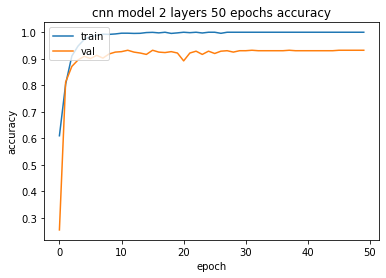

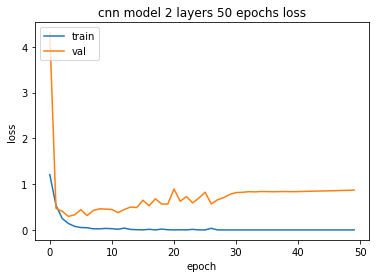

In [12]:
plot_accuracy(history_cnn_model_2_layers, "cnn model 2 layers 50 epochs")
plot_loss(history_cnn_model_2_layers, "cnn model 2 layers 50 epochs")

The model seems to be still overfitting a little bit, but at least there is an improvement in how the plot looks compared to the initial model.<br>
Since optimizing the parameters didn't yield great results, we will try to improve the performance of our model by data augmentation. After a lot of searching I managed to find a dataset with exactly the same structure, same kind of data (medical scans) and exactly the same 4 classes. This dataset contains 7022 additional images, so it will greatly improve the number of training and testing examples our model can learn from, which should also improve its performence.<br>
I believe this approach should perform better than augmenting data by means of applying transformations like rotation, zoom etc., so I will ahead and try it out in the next script (number 4). Please run that script in order to see the other appproaches used.